In [41]:
import torch
import pandas as pd
import torch.nn.functional as F
import random
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np

# **Task 1. (10 점) 데이터 준비하기**

In [42]:
#Task 1-1. (5 점) 파일을 다운로드 받고 ua.data 파일(학습데이터)과 ua.test 파일(검증데이터)의 내용을 불러와서 Tensor 데이터 생성하기
#파일 불러오기
train = pd.read_csv("ua.base", sep = "\t", names = ['user', 'movie', 'rating', 'timestamp']).fillna(0)
test = pd.read_csv("ua.test", sep = "\t", names = ['user', 'movie', 'rating', 'timestamp']).fillna(0)
#tensor 만들기
#train Data Tensor
train_items = torch.LongTensor(train['movie'])
train_users = torch.LongTensor(train['user'])
train_ratings = torch.FloatTensor(train['rating'])

#test Data Tensor
test_items = torch.LongTensor(test['movie'])
test_users = torch.LongTensor(test['user'])
test_ratings = torch.FloatTensor(test['rating'])

#Task 1-2. (5 점) u.item 파일로부터 영화 id와 title 불러오기
item = pd.read_csv("u.item", sep = "|", encoding = "latin-1", header=None).iloc[:, [0, 1]]
item.columns = ['movieID', 'movieTitle']

#test

# **Task 2. (20 점) Latent Factor 모델을 이용하여 학습하기**

In [43]:
#Task 2-1. (3 점) P, Q, bias_user, bias_item 등 파라미터 초기화하기

rank = 3
numItems = train_items.max() + 1
numUsers = train_users.max() + 1

P = torch.randn(numItems, rank, requires_grad=True) #itemMatrix (items x rank)
Q = torch.randn(numUsers, rank, requires_grad=True) #UserMatrix (users x rank)

bias_item = torch.randn(numItems, requires_grad=True)
bias_user = torch.randn(numUsers, requires_grad=True)
mean = (train_ratings.sum() / len(train_ratings)).item()

#print(bias_item)

#print("P : ", P, "\nQ : ", Q)
#print("items : ", bias_item, "\nusers : ", bias_user)

#Task 2-2. (7 점) regularization과 bias 적용하여 가설, 비용 설정하기
#Task 2-3. (5 점) torch.optim을 사용하여 학습하기

lambda1 = 0.0001
lambda2 = 0.0001
lambda3 = 0.0001
lambda4 = 0.0001

optimizer = torch.optim.Adam([P, Q, bias_item, bias_user], lr = 0.1)
X = []
Y = [] #plot을 위한 list
Y_Test = []

for epoch in range(0, 1001):
  hypothesis = torch.sum(P[train_items] * Q[train_users], dim = 1) + mean + bias_item[train_items] + bias_user[train_users]

  cost = F.mse_loss(hypothesis, train_ratings)
  loss = cost + lambda1 * torch.sum(P ** 2) + lambda2 * torch.sum(Q ** 2)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  with torch.no_grad():
    #test 는 fitting 이 아니므로 bias, mean 등 필요 x..? P, Q에 대해서도 필요 x?
    hypothesis_test = torch.sum(P[test_items] * Q[test_users], dim=1) + mean + bias_item[test_items] + bias_user[test_users]
    cost_test = F.mse_loss(hypothesis_test, test_ratings)

  X.append(epoch)
  #Y.append(cost.item()) #X ; Epoch, Y : Cost
  Y.append(loss.item() ** 0.5)
  Y_Test.append(cost_test.item() ** 0.5)

  if epoch % 100 == 0:
    print("epoch : {}, cost : {}".format(epoch, cost.item()))
  #print(torch.sum(P[2] * Q[1])) Test

#Task 2-4. (5 점) 학습데이터와 검증데이터에 대해서 각각 RMSE값을 구하여 출력하기 (training RMSE, test RMSE)
print("Training RMSE : ", Y[-1], "\nTest RMSE : ", Y_Test[-1])

epoch : 0, cost : 6.186826705932617
epoch : 100, cost : 0.7117345333099365
epoch : 200, cost : 0.6999562382698059
epoch : 300, cost : 0.6955971717834473
epoch : 400, cost : 0.6955207586288452
epoch : 500, cost : 0.6955135464668274
epoch : 600, cost : 0.6955128908157349
epoch : 700, cost : 0.6955128908157349
epoch : 800, cost : 0.6955132484436035
epoch : 900, cost : 0.6955129504203796
epoch : 1000, cost : 0.695513129234314
Training RMSE :  0.8701323262791131 
Test RMSE :  0.9358579560423617


# **Task 3. (10 점) 13번 User에게 추천하기 (knn search)**

In [44]:
#Task 3-1. (5 점) 13번 user의 예상 별점이 가장 높은 영화 top 20개를 찾아서 id 및 영화이름 출력하기
pArr = []
for i in range(1, len(P)): #item
  pArr.append((i, torch.sum(Q[13] * P[i])))

pArr = sorted(pArr, key=lambda x : x[1], reverse=True)[:20]

for x in pArr:
  print("ID : {}\nTitle : {}".format(x[0], item['movieTitle'][x[0] - 1]))

ID : 496
Title : It's a Wonderful Life (1946)
ID : 423
Title : E.T. the Extra-Terrestrial (1982)
ID : 286
Title : English Patient, The (1996)
ID : 750
Title : Amistad (1997)
ID : 197
Title : Graduate, The (1967)
ID : 162
Title : On Golden Pond (1981)
ID : 582
Title : Piano, The (1993)
ID : 887
Title : Eve's Bayou (1997)
ID : 292
Title : Rosewood (1997)
ID : 131
Title : Breakfast at Tiffany's (1961)
ID : 427
Title : To Kill a Mockingbird (1962)
ID : 124
Title : Lone Star (1996)
ID : 215
Title : Field of Dreams (1989)
ID : 97
Title : Dances with Wolves (1990)
ID : 9
Title : Dead Man Walking (1995)
ID : 419
Title : Mary Poppins (1964)
ID : 501
Title : Dumbo (1941)
ID : 14
Title : Postino, Il (1994)
ID : 378
Title : Miracle on 34th Street (1994)
ID : 404
Title : Pinocchio (1940)


In [45]:
#Task 3-2. (5 점) Latent Matrix P와 Q를 이용하여 13번 user와 cosine similarity가 가장 유사한 영화 top 20개를 찾아서 id 및 영화이름 출력하기
def cosCal(x, y):
  demon = torch.sqrt(torch.sum(x**2) * torch.sum(y**2))
  return (torch.sum(x * y) / max(demon, 0.1))

cosArr = []
for y in range (1, len(P)):
  cosArr.append([y,cosCal(Q[13], P[y])])

cosArr = sorted(cosArr, key=lambda x:x[1], reverse=True)[:20]

for x in cosArr:
  print("ID : {}\nTitle : {}".format(x[0], item['movieTitle'][x[0] - 1]))

ID : 666
Title : Blood For Dracula (Andy Warhol's Dracula) (1974)
ID : 44
Title : Dolores Claiborne (1994)
ID : 848
Title : Murder, My Sweet (1944)
ID : 8
Title : Babe (1995)
ID : 724
Title : Circle of Friends (1995)
ID : 886
Title : Life Less Ordinary, A (1997)
ID : 1503
Title : Gold Diggers: The Secret of Bear Mountain (1995)
ID : 162
Title : On Golden Pond (1981)
ID : 70
Title : Four Weddings and a Funeral (1994)
ID : 1115
Title : Twelfth Night (1996)
ID : 1463
Title : Boys, Les (1997)
ID : 1242
Title : Old Lady Who Walked in the Sea, The (Vieille qui marchait dans la mer, La) (1991)
ID : 531
Title : Shine (1996)
ID : 868
Title : Hearts and Minds (1996)
ID : 917
Title : Mercury Rising (1998)
ID : 722
Title : Nine Months (1995)
ID : 1451
Title : Foreign Correspondent (1940)
ID : 570
Title : Wyatt Earp (1994)
ID : 659
Title : Arsenic and Old Lace (1944)
ID : 1173
Title : Bliss (1997)



# **Task 4. (30 점) 영화 클러스터링하기 (k-means clustering)**

In [46]:
#Task 4-1. (15 점) 다음을 만족하는 k-means clustering알고리즘 구현하기
#각 영화가 속한 cluster를 정할 때, cosine similarity를 기준으로 정하기
#plt.scatter(*zip(*points))

def assign(p, centroids):
  max_l_point = -1
  max_l = -99 * 99
  for i, c in enumerate(centroids):
    l = cosCal(torch.tensor(p, dtype=float), torch.tensor(c, dtype=float))
    if (l > max_l): #cos유사도가 더 클경우 바꿔줌
      max_l_point = i
      max_l = l #min의 중심점과 거리를 update
  return max_l_point

def compute_centroids(k, assignments, points):
  centroids = []
  clusters = [[] for _ in range(k)]
  for a, p in zip(assignments, points):
    clusters[a].append(p)
  for c in clusters:
    if (c): centroids.append(np.mean(c, axis=0))
    else: centroids.append(0.0001)
  return centroids

def kmeans(k, points):
  pre_assignments = []
  centroids = random.choices(points, k = k)# 1. 4g : 있는 점들 중 centroids 뽑기
  #print(centroids)

  for epoch in range(10):
    #if epoch % 5 == 0: print("EPOCH : ", epoch)
    # 2. 각 점마다 가까운 centroid의 cluster 할당
    assignments = []
    for p in points:
      max_idx = assign(p, centroids)
      assignments.append(max_idx) #centroids에 따라서 속한 것들을 확인
    #assignments = [assign(p, centroids)] for p in points]
    # 3. cluster의 평균을 구해서 centroid update
    # np.array([1, 2, 3]), np. array([2, 3, 4]), np.array([3, 4, 5]) ~> (a + b + c) / 3
    # cluster에 들어가있는 점 수 -> 합계 -> 합계 / 수 ( == 평균) ---- np.mean
    centroids = compute_centroids(k, assignments, points)

    # 4. cluster가 변했는지 확인 , 변했으면 계속 !!!!!!
    if (assignments == pre_assignments):
      break

    pre_assignments = assignments   
    
  return assignments, centroids #어느 cluster인지, 중심점

n = P[1:].detach().numpy()
ass, C = kmeans(2, n)
#print(C)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


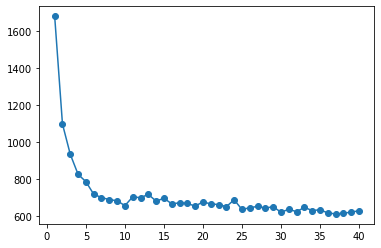

In [47]:
#Task 4-2. (10 점) k=1, ..., 40 까지 바꿔가면서 cost 값을 계산하고 이를 matplotlib을 활용하여 그래프로 그리기
selectK_idx = [x for x in range(1, 41)]
selectK = []
for i in tqdm(range(1, 41)):
  #print("K = ", i)
  ass,c = kmeans(i, P[1:].detach().numpy())
  result = 0
  for p, a in zip(P[1:], ass):
    result += 1 - cosCal(torch.tensor(p, dtype=torch.float64), torch.tensor(c[a], dtype=torch.float64))
  selectK.append(result)
  
plt.plot(selectK_idx, selectK, marker='o')
plt.show()
#Task 4-3. (5 점) 가장 적절해보이는 k 선택하기
#k = 37 정도일 때 가장 낮은 값을 보인다.

# **Task 5. (30 점) 차원 축소 및 시각화 (PCA)**

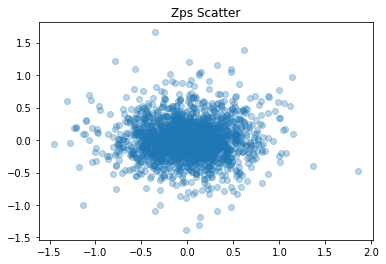

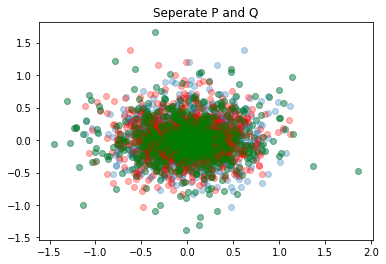

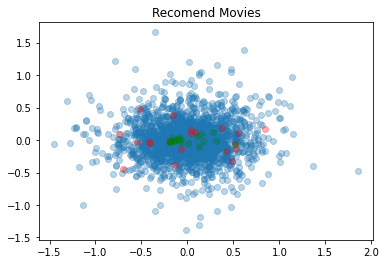

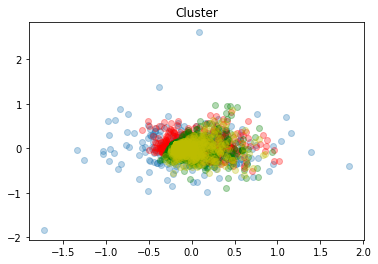

In [54]:
#Task 5-1. (5 점) P 행렬와 Q 행렬을 합쳐 Z행렬 만들기
from sklearn.decomposition import PCA

Z = np.concatenate((P.detach().numpy(), Q.detach().numpy()))
#Task 5-2. (10 점)Z 행렬에서 PCA 수행하여 2차원 데이터로 줄인 Zp 만들기
#참고: 외부 library를 사용해도 무방함

pca = PCA(n_components=2)
Zp = pca.fit_transform(torch.tensor(Z, dtype=torch.float64))
#pca.explained_variance_ratio_
#Task 5-3. matplotlib을 활용하여 Zp의 scatter plot 그리기
plt.figure(1)
plt.title('Zps Scatter')
plt.scatter(Zp[:, 0], Zp[:, 1], alpha=0.3)
#Task 5-3-1. (5 점) P행렬과 Q행렬의 점들을 서로 다른 색으로 그리기
plt.figure(2)
pr = pca.fit_transform(torch.tensor(P[1:].tolist(), dtype=torch.float64))
qr = pca.fit_transform(torch.tensor(Q.tolist(), dtype=torch.float64))
plt.title('Seperate P and Q')
plt.scatter(Zp[:, 0], Zp[:, 1], alpha=0.3)
plt.scatter(pr[:, 0], pr[:, 1], alpha=0.3, c='r')
plt.scatter(qr[:, 0], qr[:, 1], alpha=0.3, c='g')

#Task 5-3-2. (5 점) Task 3의 결과 점들을 다른 색으로 그려 강조하기
plt.figure(3)
series = [[], []]
for p, c in zip(pArr, cosArr):
  series[0].append(P[p[0]].detach().numpy())
  series[1].append(P[c[0]].detach().numpy())

plt.title('Recomend Movies')
plt.scatter(Zp[:, 0], Zp[:, 1], alpha=0.3)
Prr = pca.fit_transform(torch.tensor(series[0], dtype=torch.float64))
crr = pca.fit_transform(torch.tensor(series[1], dtype=torch.float64))
plt.scatter(Prr[:, 0], Prr[:, 1], alpha=0.3, c='r')
plt.scatter(crr[:, 0], crr[:, 1], alpha =0.3, c='g')

#Task 5-3-3. (5 점) Task 4에서 구한 cluster들을 각기 다른 색으로 그리기
plt.figure(4)
ass, c = kmeans(3, P[1:].detach().numpy())
Qass, Qc = kmeans(3, Q.detach().numpy())
clusters = [[] for _ in range(3)]
for a, p in zip(ass, P[1:].detach().numpy()):
  clusters[a].append(p)

plt.title('Cluster')

qcFrr = pca.fit_transform(torch.tensor(Qclusters[0], dtype=torch.float64))

cFrr = pca.fit_transform(torch.tensor(clusters[0], dtype=torch.float64))
cSrr = pca.fit_transform(torch.tensor(clusters[1], dtype=torch.float64))
cTrr = pca.fit_transform(torch.tensor(clusters[2], dtype=torch.float64))

plt.scatter(qcFrr[:, 0], qcFrr[:, 1], alpha = 0.3)
plt.scatter(cFrr[:, 0], cFrr[:, 1], alpha=0.3, c='r')
plt.scatter(cSrr[:, 0], cSrr[:, 1], alpha=0.3, c='g')
plt.scatter(cTrr[:, 0], cTrr[:, 1], alpha=0.3, c='y')